In [180]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Example Feature Extraction from XML Files
# We count the number of specific system calls made by the programs, and use
# these as our features.

# This code requires that the unzipped training set is in a folder called "train". 

import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util

TRAIN_DIR = "train"
TEST_DIR = "test"

call_set = set([])

def add_to_set(tree):
    for el in tree.iter():
        call = el.tag
        call_set.add(call)

def create_data_matrix(start_index, end_index, direc="train"):
    X = None
    classes = []
    ids = [] 
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break

        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        add_to_set(tree)
        this_row = call_feats(tree)
        if X is None:
            X = this_row 
        else:
            X = np.vstack((X, this_row))

    return X, np.array(classes), ids

def call_feats(tree):
    calls = ['all_section', 'bind_socket', 'check_for_debugger',
       'com_create_instance', 'com_get_class_object', 'connect',
       'connect_socket', 'copy_file', 'create_directory', 'create_file',
       'create_key', 'create_mutex', 'create_open_file', 'create_process',
       'create_socket', 'create_thread', 'create_window', 'delete_file',
       'delete_key', 'delete_value', 'destroy_window', 'dump_line',
       'enum_keys', 'enum_processes', 'enum_values', 'enum_window',
       'find_file', 'find_window', 'get_computer_name',
       'get_file_attributes', 'get_host_by_name', 'get_system_directory',
       'get_system_time', 'get_username', 'get_windows_directory',
       'impersonate_user', 'kill_process', 'load_dll', 'load_image',
       'open_file', 'open_key', 'open_mutex', 'open_process',
       'open_scmanager', 'open_service', 'open_url', 'process',
       'processes', 'query_value', 'read_section', 'read_value',
       'recv_socket', 'remove_directory', 'send_socket',
       'set_file_attributes', 'set_file_time', 'set_value',
       'set_windows_hook', 'show_window', 'sleep', 'thread',
       'trimmed_bytes', 'vm_protect', 'write_value']

    call_counter = {}
    for el in tree.iter():
        call = el.tag
        if call not in call_counter:
            call_counter[call] = 0
        else:
            call_counter[call] += 1

    call_feat_array = np.zeros(len(calls))
    for i in range(len(calls)):
        call = calls[i]
        call_feat_array[i] = 0
        if call in call_counter:
            call_feat_array[i] = call_counter[call]

    return call_feat_array

In [48]:
%%time
X_train, t_train, train_ids = create_data_matrix(0, 3086, TRAIN_DIR)

CPU times: user 36 s, sys: 2.07 s, total: 38.1 s
Wall time: 41.8 s


In [1]:
# Some new feature engineering (not done yet)
'''tree = ET.parse('train/00278ec420236020d6121dffe0cc20034422e7228.Lipler.xml')
add_to_set(tree)

for el in tree.iter('load_dll'):
    print el.attrib'''

"tree = ET.parse('train/00278ec420236020d6121dffe0cc20034422e7228.Lipler.xml')\nadd_to_set(tree)\n\nfor el in tree.iter('load_dll'):\n    print el.attrib"

In [139]:
def normalize1(array) :
    rowsum = np.sum(array)
    newrow = array / float(rowsum)
    return np.append(newrow, rowsum)

In [280]:
def mat_log(matrix, new=0) :
    logged = np.log(matrix)
    logged[logged == - float("inf")] = new
    return logged

In [188]:
import sys
import random

def see_mat(matrix, index='c', i=0) :
    if index not in ['c', 'r'] :
        print "You must choose a column or row"
        
    if index == 'c' :
        if i >= matrix.shape[1] :
            print "Column does not exist"
        else :
            return matrix[:,i]
    elif index == 'r' :
        if i >= matrix.shape[0] :
            print "Row does not exist"
        else :
            return matrix[i,:]

In [201]:
X_train_normalize1 = np.apply_along_axis(normalize1, 1, X_train)

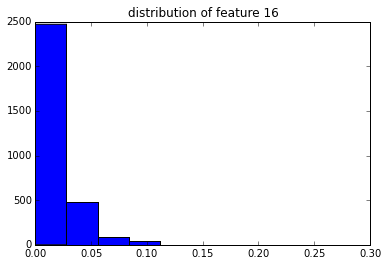

In [253]:
random_num = random.randint(0, 63)
plt.hist(see_mat(X_train_normalize1, 'c', random_num));
plt.title('distribution of feature ' + str(random_num));

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


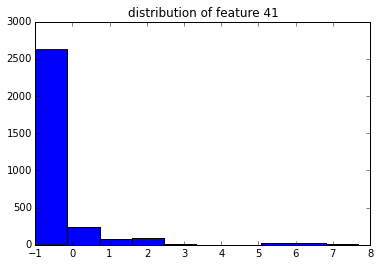

In [281]:
X_train_logged = mat_log(X_train, -1)

random_num = random.randint(0, 63)
plt.hist(see_mat(X_train_logged, 'c', random_num));
plt.title('distribution of feature ' + str(random_num));

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from IPython.kernel.zmq import kernelapp as app


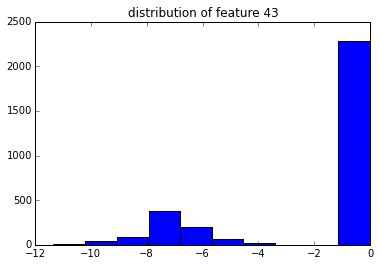

In [283]:
X_train_logged = mat_log(np.apply_along_axis(normalize1, 1, X_train), 0)

random_num = random.randint(0, 63)
plt.hist(see_mat(X_train_logged, 'c', random_num));
plt.title('distribution of feature ' + str(random_num));